<a href="https://colab.research.google.com/github/shreyasss12/Lane_LineDetection/blob/main/09_LaneLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

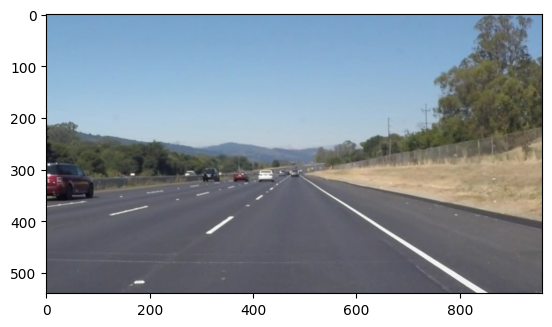

In [ ]:
#reading in an image
image = mpimg.imread('/content/sample_data/solidWhiteRight.jpg')

plt.imshow(image)

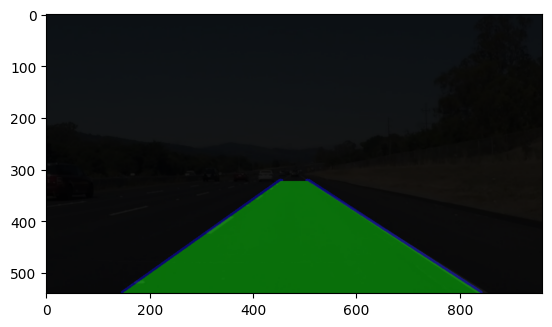

In [ ]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
   #Applies the Canny transform --> it detects and marks the edges of the picture
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    #Applies a Gaussian Noise kernel ---> it reduces the noise and smoothens the image
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #---> it helps to focus on specific part only
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    #---> checks whether img is color or greyscaled
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #--->filling pixels inside the polygon defined by "vertices" with the fill color(white)
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    #--->the code is creating a new picture (called masked_image) by only keeping the parts of the original picture that line up with the holes in the mask
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#so this img draw lines of color and thickness of choice (x1, y1)--> start , (x2, y2)--->end
def draw_lines(img, lines, color=[0, 0, 255], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#--->this is used to check whether they lean left or right
def slope_lines(image,lines):

    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #--->Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)


    for slope, intercept in [left_line, right_line]:

        #--->getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #--->taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6)

        #--->finds the lanes and draw lines on them
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))

    #--->highlight the lanes
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

#--->find out lanes in the image and redraw then on other screen
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img,lines)
    return line_img

#--->combine image
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
  return cv2.addWeighted(initial_img, α, img, β, γ)

def lane_finding_pipeline(image):
    gray_img = grayscale(image)
    blurred_img = gaussian_blur(gray_img, kernel_size=5)
    edges = canny(blurred_img, low_threshold=50, high_threshold=150)
    imshape = image.shape
    vertices = np.array([[(50, imshape[0]), (450, 320), (520, 320), (imshape[1] - 50, imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    houghed_lines = hough_lines(masked_edges, rho=1, theta=np.pi/180, threshold=30, min_line_len=100, max_line_gap=160)
    result = weighted_img(houghed_lines, image)
    return result

# Load an image for testing
image_path = '/content/sample_data/solidWhiteRight.jpg'
image = mpimg.imread(image_path)

# Process the image and display the result
processed_image = lane_finding_pipeline(image)
plt.imshow(processed_image)
plt.show()

